# Audio Classification - Audio MNIST dataset

In [22]:
import shutil
from pathlib import Path
import pickle

from tqdm import tqdm
import wisardpkg as wp
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy.io.wavfile as wav
from pyAudioAnalysis import audioSegmentation
from pyAudioAnalysis import audioBasicIO
from pyAudioAnalysis import ShortTermFeatures

from free_spoken_digit_dataset.utils.fsdd import FSDD
from free_spoken_digit_dataset.utils.spectogramer import dir_to_spectrogram


def load_audio_files(audio_dir):
    sample_rate_list = list()
    samples_list = list()
    names = list()
    files = [x for x in audio_dir.iterdir() if x.is_file()]
    for file in files:
        sample_rate, samples = wav.read(file)
        sample_rate_list.append(sample_rate)
        samples_list.append(samples)
        names.append(file.name)
        
    return sample_rate_list, samples_list, names


def plot_amplitude(samples, sample_rate, names, i):
    if isinstance(sample_rate, list):
        sample_rate_i = sample_rate[i]
    else:
        sample_rate_i = sample_rate
    
    secs = np.arange(0, len(samples[i])) / sample_rate_i
    
    fig, ax = plt.subplots(figsize=(10,5))
    _ = ax.plot(secs, samples[i])
    _ = ax.set_title(f'Sample {i} - {names[i]}')
    _ = ax.set_xlabel('Seconds')
    _ = ax.set_ylabel('Amplitude')
    plt.show()

    
def pad_samples(samples, max_n_samples=None):
    if not max_n_samples:
        max_n_samples = np.max([len(samples_i) for samples_i in samples])
    
    padded_samples = [np.append(samples_i, [0]*(max_n_samples - len(samples_i))) 
                      if len(samples_i) < max_n_samples else samples_i[:max_n_samples]  
                      for samples_i in samples]
    return padded_samples
                                
    #for i, samples_i in enumerate(samples):
    #    n_zero_pads = max_n_samples * len(samples_i)
    #    samples[i] = np.append(samples_i, [0]*n_zero_pads)
        
        
def normalize_audios(samples, max_value=None):
    if not max_value:
        max_values = [np.amax(i) for i in samples]
        max_value = np.amax(max_values)
    
    print (f'Dividing all audio samples by {max_value}')
    samples = [samples_i/ max_value for samples_i in samples]
    
    return samples


def segment_audio(samples, segment_size):
    signal_length = len(segment_size)
    segmented_audio = list()
    pass
    #for
    #    segmented_audio.append([samples[x:x + segment_size] for x in np.arange(0, signal_len, segment_size)]
    

## Loading and cleaning data

In [3]:
audio_dir = Path('free_spoken_digit_dataset/recordings/')
sample_rate, samples, names = load_audio_files(audio_dir)

Let's make sure all recordings have the same sample rate.

In [4]:
unique_sample_rate = np.unique(sample_rate)
if len(unique_sample_rate) == 1:
    sample_rate = unique_sample_rate[0]
    print(f'All recording have the same sample rate ({sample_rate} Hz)')
else:
    print(f'Different sample rates found on the recordings: {unique_sample_rate}')

All recording have the same sample rate (8000 Hz)


Now, let's see the histogram of number of samples for all the recordings.

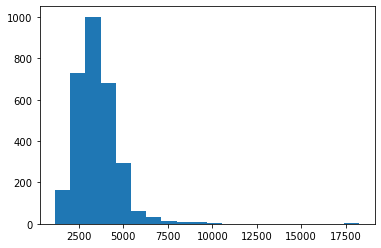

In [5]:
n_samples = [len(s) for s in samples]
_ = plt.hist(n_samples, 20)

As we can see from the histogram, there are recordings with different amount of samples, hence different duration in seconds. In order to solve that, we'll use zero padding to make sure all the recordings have the same number of samples. The number of samples chosen is 8000, which correspond to a recording of 1 second. This fixed duration of recording is chosen since most recordings have a duration of one second or less.

In [6]:
print(f'{(np.where(np.array(n_samples) <= 8000)[0].size / len(n_samples)) * 100:.2f}% recordings have a duration of 1 second or less.')

samples = pad_samples(samples, 8000)

99.33% recordings have a duration of 1 second or less.


Let's verify if now all the recordings have the same length.

In [7]:
n_samples_after_padding = [len(s) for s in samples]

if len(np.unique(n_samples_after_padding)) == 1:
    print(f'All the recordings now have the same number of samples ({np.unique(n_samples_after_padding)[0]})')
else:
    print(f'Something went wrong. The recording still have different number of samples ({np.unique(n_samples_after_padding)})')

All the recordings now have the same number of samples (8000)


In [14]:
long_audios_ids = np.where(np.array(n_samples) > 8000)[0]
long_audios_ids

array([ 149,  427,  744, 1047, 1049, 1342, 1601, 1730, 2215, 2217, 2221,
       2222, 2247, 2330, 2500, 2521, 2804, 2843, 2908, 2921], dtype=int64)

149


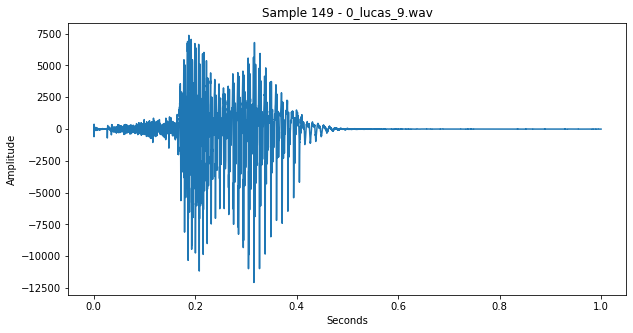

427


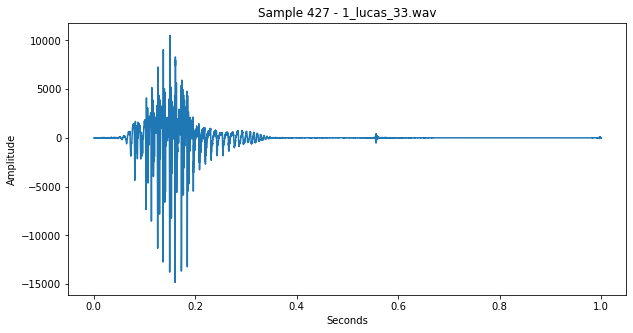

744


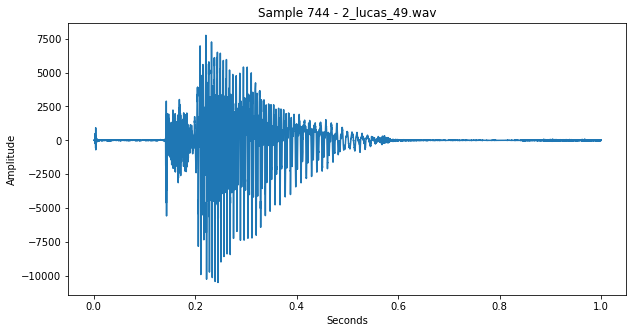

1047


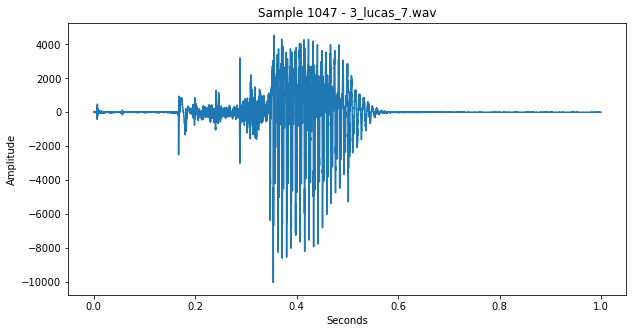

1049


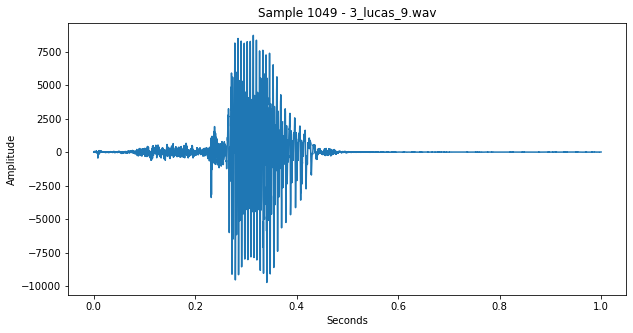

1342


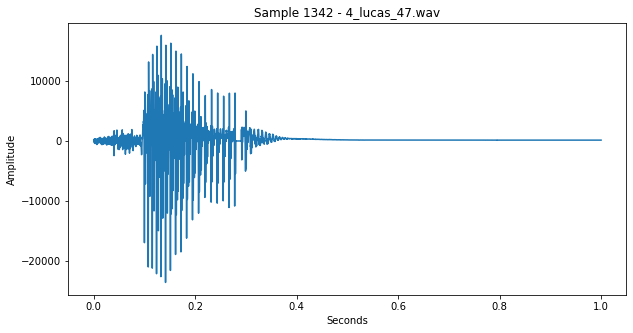

1601


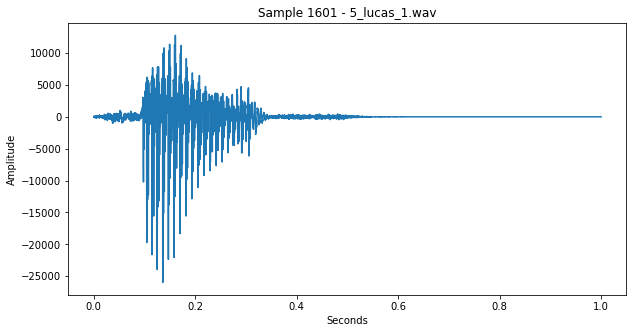

1730


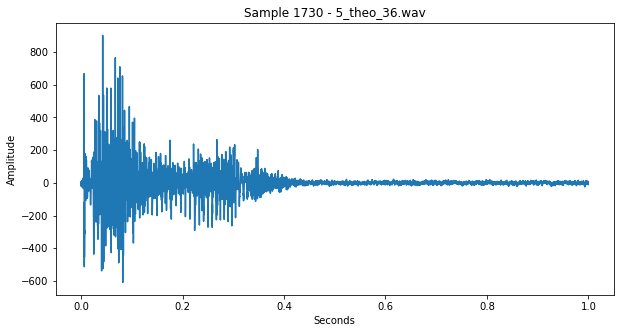

2215


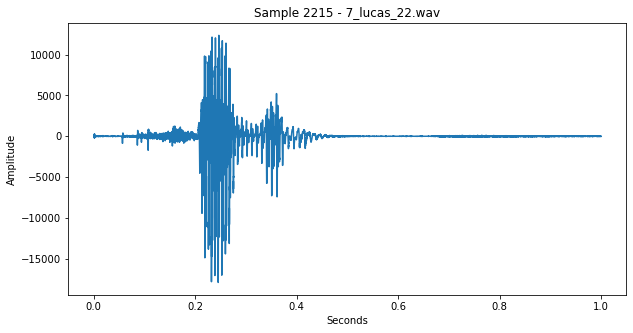

2217


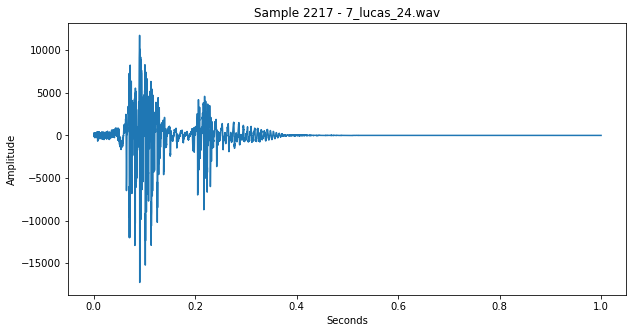

2221


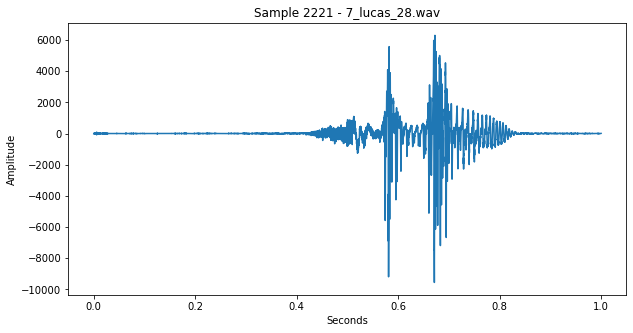

2222


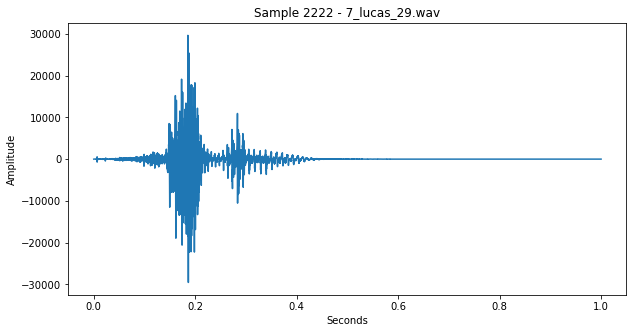

2247


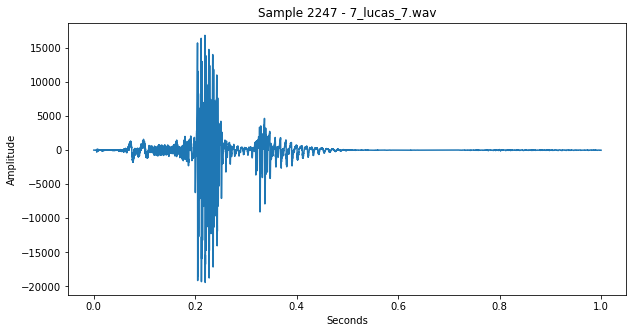

2330


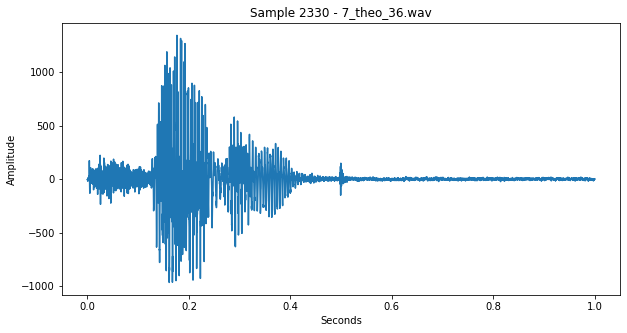

2500


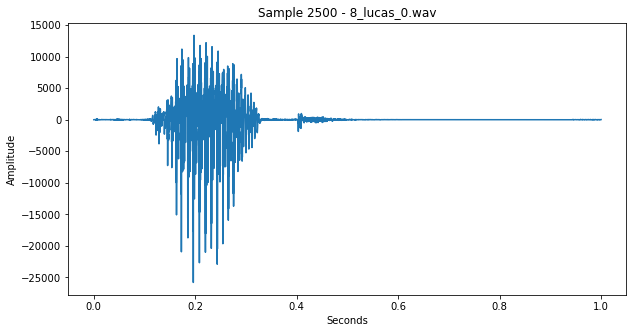

2521


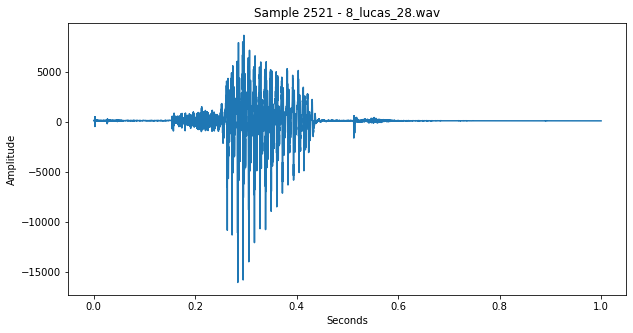

2804


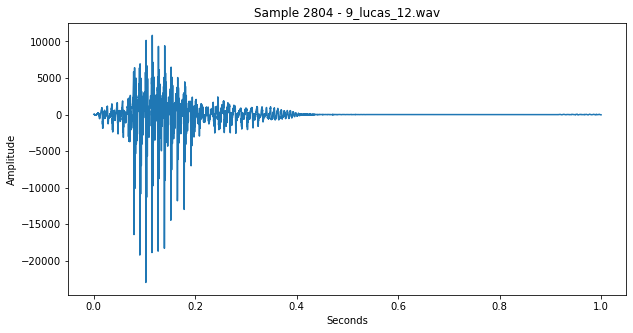

2843


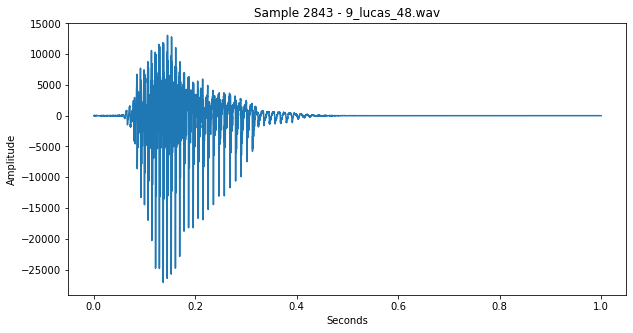

2908


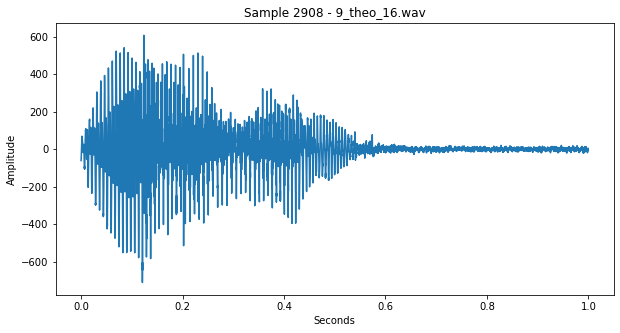

2921


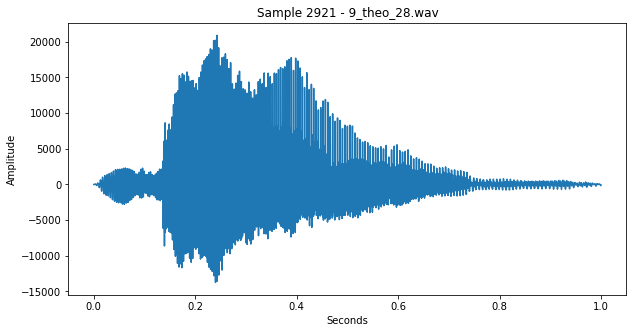

In [23]:
for long_audio_id in long_audios_ids:
    print(long_audio_id)
    plot_amplitude(samples, sample_rate, names, int(long_audio_id))

## Feature Extraction

Features to be used:

1. Spectral Centroid: Spectral centroid is simply the centroid of the FFT magnitude, normalized in the [0, Fs/2] frequency range (e.g, if Spectral Centroid = 0.5 this is equal to Fs/4 measured in Hz).
2. Spectral Spread: The second central moment of the spectrum.
3. MFCCs: Mel Frequency Cepstral Coefficients form a cepstral representation where the frequency bands are not linear but distributed according to the mel-scale.

In [25]:
np.array(samples)

array([[-1489,  -962,  -606, ...,     0,     0,     0],
       [   36,    18,    63, ...,     0,     0,     0],
       [ -175,  -509,   293, ...,     0,     0,     0],
       ...,
       [    8,     3,     8, ...,     0,     0,     0],
       [   12,     4,    15, ...,     0,     0,     0],
       [   -2,    -9,    -5, ...,     0,     0,     0]])

In [26]:
def extract_features(samples, window_size, step_size, sample_rate, features_to_keep=None):
    sample_size = len(samples[0])
    
    all_features = ['zcr', 'energy', 'energy_entropy','spectral_centroid', 'spectral_spread', 'spectral_entropy', 'spectral_flux', 'spectral_rolloff', 'mfcc_1',
                    'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'chroma_1', 'chroma_2',
                    'chroma_3', 'chroma_4', 'chroma_5', 'chroma_6', 'chroma_7', 'chroma_8', 'chroma_9', 'chroma_10', 'chroma_11', 'chroma_12', 'chroma_std', 'delta zcr',
                    'delta energy', 'delta energy_entropy', 'delta spectral_centroid', 'delta spectral_spread', 'delta spectral_entropy', 'delta spectral_flux',
                    'delta spectral_rolloff', 'delta mfcc_1', 'delta mfcc_2', 'delta mfcc_3', 'delta mfcc_4', 'delta mfcc_5', 'delta mfcc_6', 'delta mfcc_7', 
                    'delta mfcc_8', 'delta mfcc_9', 'delta mfcc_10', 'delta mfcc_11', 'delta mfcc_12', 'delta mfcc_13', 'delta chroma_1', 'delta chroma_2', 
                    'delta chroma_3', 'delta chroma_4', 'delta chroma_5', 'delta chroma_6', 'delta chroma_7', 'delta chroma_8', 'delta chroma_9', 'delta chroma_10', 
                    'delta chroma_11', 'delta chroma_12', 'delta chroma_std']
    
    features = list()
    
    if not features_to_keep:
        features_to_keep = ['spectral_centroid', 'spectral_spread', 'mfcc_1','mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 
                            'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12']
    
    features_to_keep_ids = [i for i,f in enumerate(all_features) if f in features_to_keep]
    final_feature_names = []
    
    for sample_i in tqdm(samples):
        F, f_names = ShortTermFeatures.feature_extraction(sample_i, sample_rate, window_size*sample_rate, step_size*sample_rate)
        features.append(F[features_to_keep_ids, :].flatten())
        if not final_feature_names:
            n_windows = F.shape[1]
            
            print(f'For window_size={window_size} secs, step_size={step_size} secs and sample_size={sample_size/sample_rate} secs '
                  f'there will be {np.ceil((sample_size/sample_rate)/window_size).astype(int)} windows.')
            
            windows_str = [f'_w{w+1}' for w in range(n_windows)]
            final_feature_names = [feature_name + window_name for feature_name in features_to_keep for window_name in windows_str]
    
    return features, final_feature_names


In [27]:
samples_features, feature_names = extract_features(samples, window_size=0.05, step_size=0.05, sample_rate=sample_rate)

  0%|          | 11/3000 [00:00<01:02, 48.14it/s]

For window_size=0.05 secs, step_size=0.05 secs and sample_size=1.0 secs there will be 20 windows.


100%|██████████| 3000/3000 [01:10<00:00, 42.62it/s]


Let's check how many features we have for each sample recording.

In [28]:
np.array(samples_features).shape

(3000, 280)

Let's create the labels from the name of the recordings' files.

In [29]:
y = [int(n[:1]) for n in names]
np.unique(y)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

Now we need to separate the dataset in train and test set.

In [30]:
def split_train_and_test(samples, labels, file_names):
    X_train = list()
    y_train = list()
    X_test = list()
    y_test = list()
    
    for i, file_name in enumerate(file_names):
        rec_number = int(file_name.split('_')[-1].split('.')[0])
        if rec_number in [0, 1, 2, 3, 4]:
            X_test.append(samples[i])
            y_test.append(labels[i])
        else:
            X_train.append(samples[i])
            y_train.append(labels[i])
    
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = split_train_and_test(samples_features, y, names)

In [31]:
np.array(X_test).shape

(300, 280)

## Feature Selection with Logistic Regression

In [191]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

scaler = StandardScaler()
lr = LogisticRegression(max_iter=600, penalty='l1', solver='saga')

pipe = Pipeline([('std', scaler), ('lr', lr)])

gs = GridSearchCV(pipe, param_grid={'lr__C': [0.01, 0.1, 1.0, 10, 100]}, cv=5, 
                  refit=True, verbose=1, n_jobs=-1)
gs.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  7.8min finished
C:\Users\bruno\anaconda3\envs\wisard\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('std', StandardScaler()),
                                       ('lr',
                                        LogisticRegression(max_iter=600,
                                                           penalty='l1',
                                                           solver='saga'))]),
             n_jobs=-1, param_grid={'lr__C': [0.01, 0.1, 1.0, 10, 100]},
             verbose=1)

In [196]:
pd.DataFrame(gs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lr__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,88.829699,6.532369,0.024135,0.022358,0.01,{'lr__C': 0.01},0.609259,0.566667,0.483333,0.750000,0.577778,0.597407,0.086912,5
1,112.806686,1.531388,0.015558,0.007638,0.1,{'lr__C': 0.1},0.688889,0.850000,0.803704,0.894444,0.751852,0.797778,0.072212,4
2,161.636097,4.373889,0.007580,0.001018,1,{'lr__C': 1.0},0.683333,0.874074,0.870370,0.901852,0.794444,0.824815,0.079216,1
3,171.483696,4.100141,0.009774,0.006598,10,{'lr__C': 10},0.675926,0.872222,0.850000,0.900000,0.792593,0.818148,0.079396,2
4,149.024778,24.030932,0.003391,0.000489,100,{'lr__C': 100},0.675926,0.870370,0.850000,0.903704,0.787037,0.817407,0.080317,3


In [240]:
gs.score(X_test, y_test)

0.95

In [40]:
feature_importance = np.sum(np.abs(gs.best_estimator_['lr'].coef_), axis=0)
feature_importance = feature_importance / feature_importance.sum()
feature_importance

array([1.30117258e-02, 4.42953156e-03, 1.32478571e-03, 3.06782714e-03,
       5.41742736e-03, 6.63412163e-03, 4.97493963e-03, 6.63457852e-03,
       5.49396165e-03, 3.87391387e-03, 3.80242968e-03, 1.47421889e-03,
       1.35411259e-03, 6.12251863e-04, 1.71072840e-04, 0.00000000e+00,
       4.62231408e-05, 1.08107306e-05, 8.08848869e-05, 1.21036781e-04,
       1.04529971e-02, 1.09015728e-02, 7.96529013e-03, 4.36942787e-03,
       5.56445248e-03, 1.59805521e-03, 2.95589683e-03, 5.33742399e-03,
       1.31936750e-03, 3.20722497e-04, 2.57652197e-04, 6.75991722e-05,
       4.46050752e-04, 1.56774429e-04, 1.09841712e-04, 2.48912445e-04,
       0.00000000e+00, 0.00000000e+00, 1.29424199e-04, 4.87002598e-04,
       8.02832175e-03, 6.91704266e-03, 7.06495467e-03, 5.68378134e-03,
       4.01675523e-03, 4.70557757e-03, 3.63036999e-03, 1.97523429e-03,
       2.81215832e-04, 2.56254889e-04, 3.56816069e-04, 2.72824233e-04,
       1.60874822e-04, 5.83728685e-04, 3.94997010e-04, 1.61860886e-04,
      

<AxesSubplot:ylabel='name'>

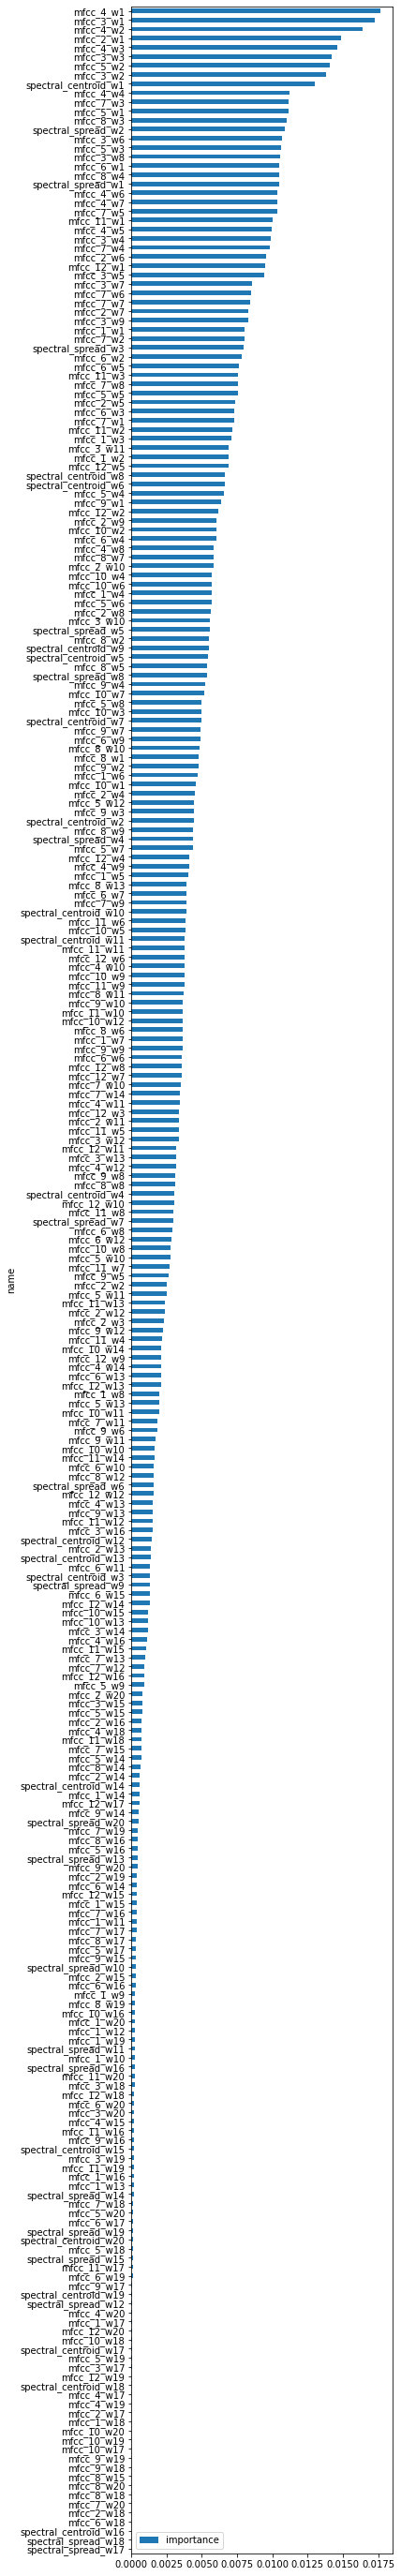

In [41]:
feature_importance_df = pd.DataFrame(columns=['name', 'importance'])
feature_importance_df['name'] = feature_names
feature_importance_df['importance'] = feature_importance

fig, ax = plt.subplots(figsize=(5, 50))
feature_importance_df.sort_values('importance', ascending=True, inplace=True)
feature_importance_df.plot(kind='barh', y='importance', x='name', ax=ax)

In [42]:
feature_importance_df.sort_values('importance', ascending=False, inplace=True)
feature_importance_df.reset_index(drop=True, inplace=False)

total_importance = feature_importance_df['importance'].sum()
top_importance = feature_importance_df.iloc[:140, :]['importance'].sum()
top_importance / total_importance

0.9022129251989631

In [43]:
with open('feature_importance.pickle', 'wb') as file:
    pickle.dump(feature_importance_df, file)

with open('grid_search_lg.pickle', 'wb') as file:
    pickle.dump(gs, file)

In [34]:
with open('feature_importance.pickle', 'rb') as file:
    feature_importance_df = pickle.load(file)

with open('grid_search_lg.pickle', 'rb') as file:
    gs = pickle.load(file)

In [44]:
most_important_features = list(feature_importance_df.iloc[:140, :]['name'].values)

In [45]:
most_important_features

['mfcc_4_w1',
 'mfcc_3_w1',
 'mfcc_4_w2',
 'mfcc_2_w1',
 'mfcc_4_w3',
 'mfcc_3_w3',
 'mfcc_5_w2',
 'mfcc_3_w2',
 'spectral_centroid_w1',
 'mfcc_4_w4',
 'mfcc_7_w3',
 'mfcc_5_w1',
 'mfcc_8_w3',
 'spectral_spread_w2',
 'mfcc_3_w6',
 'mfcc_5_w3',
 'mfcc_3_w8',
 'mfcc_6_w1',
 'mfcc_8_w4',
 'spectral_spread_w1',
 'mfcc_4_w6',
 'mfcc_4_w7',
 'mfcc_7_w5',
 'mfcc_11_w1',
 'mfcc_4_w5',
 'mfcc_3_w4',
 'mfcc_7_w4',
 'mfcc_2_w6',
 'mfcc_12_w1',
 'mfcc_3_w5',
 'mfcc_3_w7',
 'mfcc_7_w6',
 'mfcc_7_w7',
 'mfcc_2_w7',
 'mfcc_3_w9',
 'mfcc_1_w1',
 'mfcc_7_w2',
 'spectral_spread_w3',
 'mfcc_6_w2',
 'mfcc_6_w5',
 'mfcc_11_w3',
 'mfcc_7_w8',
 'mfcc_5_w5',
 'mfcc_2_w5',
 'mfcc_6_w3',
 'mfcc_7_w1',
 'mfcc_11_w2',
 'mfcc_1_w3',
 'mfcc_3_w11',
 'mfcc_1_w2',
 'mfcc_12_w5',
 'spectral_centroid_w8',
 'spectral_centroid_w6',
 'mfcc_5_w4',
 'mfcc_9_w1',
 'mfcc_12_w2',
 'mfcc_2_w9',
 'mfcc_10_w2',
 'mfcc_6_w4',
 'mfcc_4_w8',
 'mfcc_8_w7',
 'mfcc_2_w10',
 'mfcc_10_w4',
 'mfcc_10_w6',
 'mfcc_1_w4',
 'mfcc_5_w6',
 'mfc

## Feature Transformation

In [71]:
from sklearn.base import BaseEstimator, TransformerMixin
from typing import List, Union, Optional
from time import time
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ParameterGrid

class ThermometerEncoding(BaseEstimator, TransformerMixin):
    
    def __init__(self, columns : List[int], n_bits : int, min_value : Optional[Union[List[float], float]] = None, 
                 max_value : Optional[Union[List[float], float]] = None):
        self.columns = columns
        self.n_bits = n_bits
        self.min_value = min_value
        self.max_value = max_value
        self._bins = {}
    
    @property
    def min_value(self):
        return self._min_value

    @min_value.setter
    def min_value(self, value):
        if isinstance(value, list) or value is None:
             self._min_value = value
        else:
            self._min_value = [value] * len(self.columns)
    
    @property
    def max_value(self):
        return self._max_value

    @max_value.setter
    def max_value(self, value):
        if isinstance(value, list) or value is None:
             self._max_value = value
        else:
            self._max_value = [value] * len(self.columns)
    
    
    def fit(self, x, y=None):
        if not isinstance(x, np.ndarray):
            x = np.array(x)
        
        if not self.min_value:
            self.min_value = []
            for c in self.columns:
                self.min_value.append(np.min(x[:, c]))
        
        if not self.max_value:
            self.max_value = []
            for c in self.columns:
                self.max_value.append(np.max(x[:, c]))
        
        for i, c in enumerate(self.columns):            
            self._bins[c] =  np.histogram_bin_edges([], bins=self.n_bits, range=(self.min_value[i], self.max_value[i]))
        
        return self
                
    
    def transform(self, x):
        x_encoded = np.array([])
        n_columns = x.shape[1]
        for c in range(n_columns):
            if c in self.columns:
                column_encoded = np.zeros(shape=(x.shape[0], self.n_bits))
                for i in range(self.n_bits):
                    mask = (x[:, c] > self._bins[c][i])
                    column_encoded[mask, i] = 1
            else:
                column_encoded = x[:, c].reshape(-1, 1)
            
            if x_encoded.size == 0:                
                x_encoded = column_encoded
            else:
                x_encoded = np.hstack((x_encoded, column_encoded))
        
        return x_encoded      


def cross_validation_wisard(X, y, n_splits=5, addressSize=[50], thermometer_size=[5], bleachingActivated=[True], 
                            thermometer_columns=None):
    grid_search_results = []
    best_params = None
    best_accuracy = -1
    
    if not thermometer_columns:
        thermometer_columns = list(range(X.shape[1]))
    
    param_grid_dict = dict()
    param_grid_dict['thermometer_size'] = thermometer_size
    param_grid_dict['addressSize'] = addressSize
    param_grid_dict['bleachingActivated'] = bleachingActivated
    
    skf = StratifiedKFold(n_splits=n_splits)
    
    param_grid = ParameterGrid(param_grid_dict)
    
    param_grid_combinations = len(list(param_grid))
    n_combs = n_splits * param_grid_combinations
    progress = tqdm(total=n_combs, position=0, leave=True)
    
    for params in param_grid:
        print(params)
        training_time = []
        training_prediction_time = []
        validation_prediction_time = []
        thermometer_time = []
        training_accuracy = []
        validation_accuracy = []
        for train_index, val_index in skf.split(X, y):
            X_train = X[train_index, :]
            y_train = y[train_index]
            y_train_str = [str(l) for l in y_train]
            
            X_val = X[val_index, :]
            y_val = y[val_index]
            y_val_str = [str(l) for l in y_val]
            
            model = wp.Wisard(params['addressSize'], bleachingActivated=params['bleachingActivated'])
            thermometer = ThermometerEncoding(thermometer_columns, n_bits=params['thermometer_size'])
            
            start = time()
            X_train = thermometer.fit_transform(X_train).astype(int).tolist()
            X_val = thermometer.transform(X_val).astype(int).tolist()
            end = time()
            thermometer_time.append(end-start)
            
            start = time()
            model.train(X_train, y_train_str)
            end = time()
            training_time.append(end-start)
            
            start = time()
            pred_train = model.classify(X_train)
            end = time()
            training_prediction_time.append(end-start)
            
            start = time()
            pred_val = model.classify(X_val)
            end = time()
            validation_prediction_time.append(end-start)
            
            training_accuracy.append(accuracy_score(y_train_str, pred_train))
            
            validation_accuracy.append(accuracy_score(y_val_str, pred_val))
            
            progress.update()
        
        cv_result = {'training_time_mean': np.mean(training_time),
                     'training_time_std': np.std(training_time),
                     'training_prediction_time_mean': np.mean(training_prediction_time),
                     'training_prediction_time_std': np.std(training_prediction_time),
                     'validation_prediction_time_mean': np.mean(validation_prediction_time),
                     'validation_prediction_time_std': np.std(validation_prediction_time),
                     'thermometer_time_mean': np.mean(thermometer_time),
                     'thermometer_time_std': np.std(thermometer_time),
                     'training_accuracy_mean': np.mean(training_accuracy),
                     'training_accuracy_std': np.std(training_accuracy),
                     'validation_accuracy_mean': np.mean(validation_accuracy),
                     'validation_accuracy_std': np.std(validation_accuracy)}
        
        cv_result = {**params, **cv_result}
        
        grid_search_results.append(cv_result)
        
        if (cv_result['validation_accuracy_mean'] > best_accuracy):
            best_accuracy = cv_result['validation_accuracy_mean']
            best_params = params
        
        print(f"Train acc. mean: {cv_result['training_accuracy_mean']:.4f} | Validation acc. mean: {cv_result['validation_accuracy_mean']:.4f}\n")
    
    grid_search_results = pd.DataFrame(grid_search_results)
    grid_search_results['rank'] = grid_search_results['validation_accuracy_mean'].rank(ascending=False)
    
    return grid_search_results, best_params

In [72]:
most_important_features_ids = [i for i,f in enumerate(feature_names) if f in most_important_features]
X_train_best_features = np.array(X_train)[:, most_important_features_ids]
X_test_best_features = np.array(X_test)[:, most_important_features_ids]

print(f'Train set shape with best features: {X_train2.shape}')
print(f'Test set shape with best features: {X_test2.shape}')

Train set shape with best features: (2700, 140)
Test set shape with best features: (300, 140)


In [73]:
ws_gs_results, ws_best_params = cross_validation_wisard(X_train_best_features, np.array(y_train), n_splits=5, addressSize=[5, 10, 20, 50, 64], 
                                                        thermometer_size=[3, 5, 7], bleachingActivated=[True, False])

  0%|          | 0/150 [00:00<?, ?it/s]

{'addressSize': 5, 'bleachingActivated': True, 'thermometer_size': 3}


  3%|▎         | 5/150 [00:02<01:24,  1.71it/s]

Train acc. mean: 0.8671 | Validation acc. mean: 0.5593

{'addressSize': 5, 'bleachingActivated': True, 'thermometer_size': 5}


  7%|▋         | 10/150 [00:07<01:54,  1.22it/s]

Train acc. mean: 0.9300 | Validation acc. mean: 0.6311

{'addressSize': 5, 'bleachingActivated': True, 'thermometer_size': 7}


 10%|█         | 15/150 [00:13<02:40,  1.19s/it]

Train acc. mean: 0.9594 | Validation acc. mean: 0.6781

{'addressSize': 5, 'bleachingActivated': False, 'thermometer_size': 3}


 13%|█▎        | 20/150 [00:16<01:16,  1.70it/s]

Train acc. mean: 0.6755 | Validation acc. mean: 0.4585

{'addressSize': 5, 'bleachingActivated': False, 'thermometer_size': 5}


 17%|█▋        | 25/150 [00:20<01:32,  1.35it/s]

Train acc. mean: 0.8391 | Validation acc. mean: 0.5389

{'addressSize': 5, 'bleachingActivated': False, 'thermometer_size': 7}


 20%|██        | 30/150 [00:25<02:09,  1.08s/it]

Train acc. mean: 0.9058 | Validation acc. mean: 0.6252

{'addressSize': 10, 'bleachingActivated': True, 'thermometer_size': 3}


 23%|██▎       | 35/150 [00:27<01:02,  1.85it/s]

Train acc. mean: 0.9588 | Validation acc. mean: 0.6348

{'addressSize': 10, 'bleachingActivated': True, 'thermometer_size': 5}


 27%|██▋       | 40/150 [00:31<01:15,  1.46it/s]

Train acc. mean: 0.9815 | Validation acc. mean: 0.6948

{'addressSize': 10, 'bleachingActivated': True, 'thermometer_size': 7}


 30%|███       | 45/150 [00:36<01:37,  1.07it/s]

Train acc. mean: 0.9920 | Validation acc. mean: 0.7285

{'addressSize': 10, 'bleachingActivated': False, 'thermometer_size': 3}


 33%|███▎      | 50/150 [00:38<00:51,  1.94it/s]

Train acc. mean: 0.9195 | Validation acc. mean: 0.5985

{'addressSize': 10, 'bleachingActivated': False, 'thermometer_size': 5}


 37%|███▋      | 55/150 [00:42<01:10,  1.35it/s]

Train acc. mean: 0.9658 | Validation acc. mean: 0.6733

{'addressSize': 10, 'bleachingActivated': False, 'thermometer_size': 7}


 40%|████      | 60/150 [00:48<01:37,  1.08s/it]

Train acc. mean: 0.9861 | Validation acc. mean: 0.7256

{'addressSize': 20, 'bleachingActivated': True, 'thermometer_size': 3}


 43%|████▎     | 65/150 [00:50<00:47,  1.80it/s]

Train acc. mean: 0.9962 | Validation acc. mean: 0.6774

{'addressSize': 20, 'bleachingActivated': True, 'thermometer_size': 5}


 47%|████▋     | 70/150 [00:54<00:54,  1.46it/s]

Train acc. mean: 0.9990 | Validation acc. mean: 0.7559

{'addressSize': 20, 'bleachingActivated': True, 'thermometer_size': 7}


 50%|█████     | 75/150 [00:59<01:24,  1.12s/it]

Train acc. mean: 0.9996 | Validation acc. mean: 0.7700

{'addressSize': 20, 'bleachingActivated': False, 'thermometer_size': 3}


 53%|█████▎    | 80/150 [01:02<00:37,  1.86it/s]

Train acc. mean: 0.9923 | Validation acc. mean: 0.6667

{'addressSize': 20, 'bleachingActivated': False, 'thermometer_size': 5}


 57%|█████▋    | 85/150 [01:05<00:39,  1.64it/s]

Train acc. mean: 0.9993 | Validation acc. mean: 0.7167

{'addressSize': 20, 'bleachingActivated': False, 'thermometer_size': 7}


 60%|██████    | 90/150 [01:10<00:57,  1.04it/s]

Train acc. mean: 0.9997 | Validation acc. mean: 0.7663

{'addressSize': 50, 'bleachingActivated': True, 'thermometer_size': 3}


 63%|██████▎   | 95/150 [01:12<00:33,  1.66it/s]

Train acc. mean: 1.0000 | Validation acc. mean: 0.4207

{'addressSize': 50, 'bleachingActivated': True, 'thermometer_size': 5}


 67%|██████▋   | 100/150 [01:15<00:31,  1.59it/s]

Train acc. mean: 1.0000 | Validation acc. mean: 0.4863

{'addressSize': 50, 'bleachingActivated': True, 'thermometer_size': 7}


 70%|███████   | 105/150 [01:20<00:42,  1.06it/s]

Train acc. mean: 1.0000 | Validation acc. mean: 0.5241

{'addressSize': 50, 'bleachingActivated': False, 'thermometer_size': 3}


 73%|███████▎  | 110/150 [01:22<00:19,  2.02it/s]

Train acc. mean: 1.0000 | Validation acc. mean: 0.4204

{'addressSize': 50, 'bleachingActivated': False, 'thermometer_size': 5}


 77%|███████▋  | 115/150 [01:25<00:21,  1.65it/s]

Train acc. mean: 1.0000 | Validation acc. mean: 0.4648

{'addressSize': 50, 'bleachingActivated': False, 'thermometer_size': 7}


 80%|████████  | 120/150 [01:30<00:25,  1.18it/s]

Train acc. mean: 1.0000 | Validation acc. mean: 0.5119

{'addressSize': 64, 'bleachingActivated': True, 'thermometer_size': 3}


 83%|████████▎ | 125/150 [01:32<00:12,  2.08it/s]

Train acc. mean: 1.0000 | Validation acc. mean: 0.3052

{'addressSize': 64, 'bleachingActivated': True, 'thermometer_size': 5}


 87%|████████▋ | 130/150 [01:35<00:11,  1.68it/s]

Train acc. mean: 1.0000 | Validation acc. mean: 0.3248

{'addressSize': 64, 'bleachingActivated': True, 'thermometer_size': 7}


 90%|█████████ | 135/150 [01:40<00:12,  1.17it/s]

Train acc. mean: 1.0000 | Validation acc. mean: 0.3793

{'addressSize': 64, 'bleachingActivated': False, 'thermometer_size': 3}


 93%|█████████▎| 140/150 [01:42<00:04,  2.03it/s]

Train acc. mean: 1.0000 | Validation acc. mean: 0.3111

{'addressSize': 64, 'bleachingActivated': False, 'thermometer_size': 5}


 97%|█████████▋| 145/150 [01:45<00:03,  1.56it/s]

Train acc. mean: 1.0000 | Validation acc. mean: 0.3319

{'addressSize': 64, 'bleachingActivated': False, 'thermometer_size': 7}


100%|██████████| 150/150 [01:50<00:00,  1.09it/s]

Train acc. mean: 1.0000 | Validation acc. mean: 0.3711



In [75]:
ws_best_params

{'addressSize': 20, 'bleachingActivated': True, 'thermometer_size': 7}

In [74]:
ws_gs_results = ws_gs_results.sort_values('rank').reset_index(drop=True)

with open('results/wisard_best_features_gs_results.pickle', 'wb') as file:
    pickle.dump(ws_gs_results, file)

ws_gs_results

,addressSize,bleachingActivated,thermometer_size,training_time_mean,training_time_std,training_prediction_time_mean,training_prediction_time_std,validation_prediction_time_mean,validation_prediction_time_std,thermometer_time_mean,thermometer_time_std,training_accuracy_mean,training_accuracy_std,validation_accuracy_mean,validation_accuracy_std,rank
0,20,True,7,0.052261,0.005069,0.185894,0.023328,0.045288,0.004392,0.866206,0.110159,0.999630,0.000346,0.770000,0.096683,1.0
1,20,False,7,0.045271,0.004449,0.174133,0.042755,0.040303,0.006495,0.714149,0.059203,0.999722,0.000370,0.766296,0.093546,2.0
2,20,True,5,0.032695,0.004232,0.120792,0.020818,0.031717,0.004296,0.545344,0.057683,0.998981,0.000944,0.755926,0.105060,3.0
3,10,True,7,0.042877,0.001404,0.195294,0.004905,0.051663,0.003058,0.672204,0.016727,0.992037,0.002658,0.728519,0.092701,4.0
4,10,False,7,0.048481,0.004834,0.229583,0.031141,0.060447,0.012408,0.745796,0.089163,0.986111,0.004068,0.725556,0.089054,5.0
5,20,False,5,0.028327,0.001017,0.098928,0.004348,0.024742,0.001157,0.470379,0.026063,0.999259,0.000628,0.716667,0.112186,6.0
6,10,True,5,0.030524,0.001199,0.148590,0.003935,0.038508,0.000495,0.486311,0.008988,0.981481,0.001898,0.694815,0.084192,7.0
7,5,True,7,0.054730,0.006968,0.358254,0.022990,0.092354,0.001853,0.794870,0.100093,0.959352,0.006576,0.678148,0.076456,8.0
8,20,True,3,0.019554,0.001352,0.067611,0.006786,0.017959,0.001991,0.332940,0.049396,0.996204,0.001476,0.677407,0.089346,9.0
9,10,False,5,0.033320,0.002939,0.179902,0.041208,0.041305,0.004633,0.530652,0.047075,0.965833,0.008658,0.673333,0.092538,10.0
